## Importing the required libraries

In [1]:
from colpali_engine.models import ColQwen2, ColQwen2Processor
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

import numpy as np 
import torch

## Loading the model and processor


In [2]:
import torch

# Check if CUDA/MPS is available
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{device = }")

device = 'mps'


In [3]:
model_name = "vidore/colqwen2-v0.1"
model = ColQwen2.from_pretrained(
                pretrained_model_name_or_path=model_name,
                torch_dtype=torch.bfloat16,
                device_map=device, 
                cache_dir="./model_cache"
            )

processor = ColQwen2Processor.from_pretrained(
                pretrained_model_name_or_path=model_name,
                cache_dir="./model_cache"
            )

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# Setting the model to evaluation mode
model.eval()
model

ColQwen2(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Sequential(
        (0): L

## Downloading the dataset

In [5]:
import os
import requests

# Downloading the dataset 
# url = "https://reseauactionclimat.org/wp-content/uploads/2018/04/powerpoint-final-kit.pdf"
url = "https://arxiv.org/pdf/1706.03762.pdf"

# Set the filename and filepath
filename = "test.pdf"
filepath = os.path.join("data", filename)

# Create the data directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open(filepath, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully: {filepath}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully: data/test.pdf


In [6]:
# # Local file path
# filepath = "data/lec_04.pdf"

## Converting PDF to Images


In [7]:
import base64
from io import BytesIO
import pymupdf
from tqdm import tqdm
from PIL import Image


# Define the function to process each page of the PDF
def process_page_images(page, page_num, base_dir):
    # Create a pixmap from the PDF page
    pix = page.get_pixmap()

    # Define the path where the image will be saved
    page_path = os.path.join(base_dir, f"page_{page_num:03d}.jpeg")

    # Save the pixmap as a JPEG image
    pix.save(page_path)

    # Open the saved image file and convert it to a base64 string
    with open(page_path, 'rb') as file:
        encoded_image = base64.b64encode(file.read()).decode('utf8')

    # Convert the base64 string back to a bytes object and create a PIL image
    image_data = BytesIO(base64.b64decode(encoded_image))
    page_image_pil = Image.open(image_data)

    # Return the PIL image object
    return page_image_pil

In [8]:
doc = pymupdf.open(filepath)
num_pages = len(doc)
output_dir = "data/processed_page_images"

images = []

# Make sure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each page of the PDF
for page_num in tqdm(range(num_pages), desc="Processing PDF pages"):
    page = doc[page_num]
    image = process_page_images(page, page_num, output_dir)
    images.append(image)

Processing PDF pages: 100%|██████████| 15/15 [00:00<00:00, 28.52it/s]


In [9]:
# Loading the images into a dataloader

dataloader = DataLoader(
                            dataset=images,
                            batch_size=2,
                            shuffle=False,
                            collate_fn=lambda x: processor.process_images(x),
                        )

images_embeddings  = []
for batch_doc in tqdm(dataloader):
    with torch.no_grad():
        batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
        embeddings_doc = model(**batch_doc)
    images_embeddings.extend(list(torch.unbind(embeddings_doc.to("cpu"))))


100%|██████████| 8/8 [01:38<00:00, 12.29s/it]


## Retrieval 

In [10]:
def get_results(query, topk):
    batch_queries = processor.process_queries([query]).to(model.device)

    # Forward pass
    with torch.no_grad():
        query_embeddings = model(**batch_queries)

    scores = processor.score_multi_vector(query_embeddings, images_embeddings)
    scores = scores.squeeze(0)

    close_vectors_id = scores.topk(topk).indices.tolist()
    # get top-k scores
    return close_vectors_id

In [11]:
# query = "What animals are in danger with climate change ?"
# query = "What are the different modern transformer based model available ?"
query = "What is position embedding in transformer models?"
k = 6

context_ids = get_results(query=query, topk=k)

In [12]:
context_ids

[2, 8, 0, 4, 1, 5]

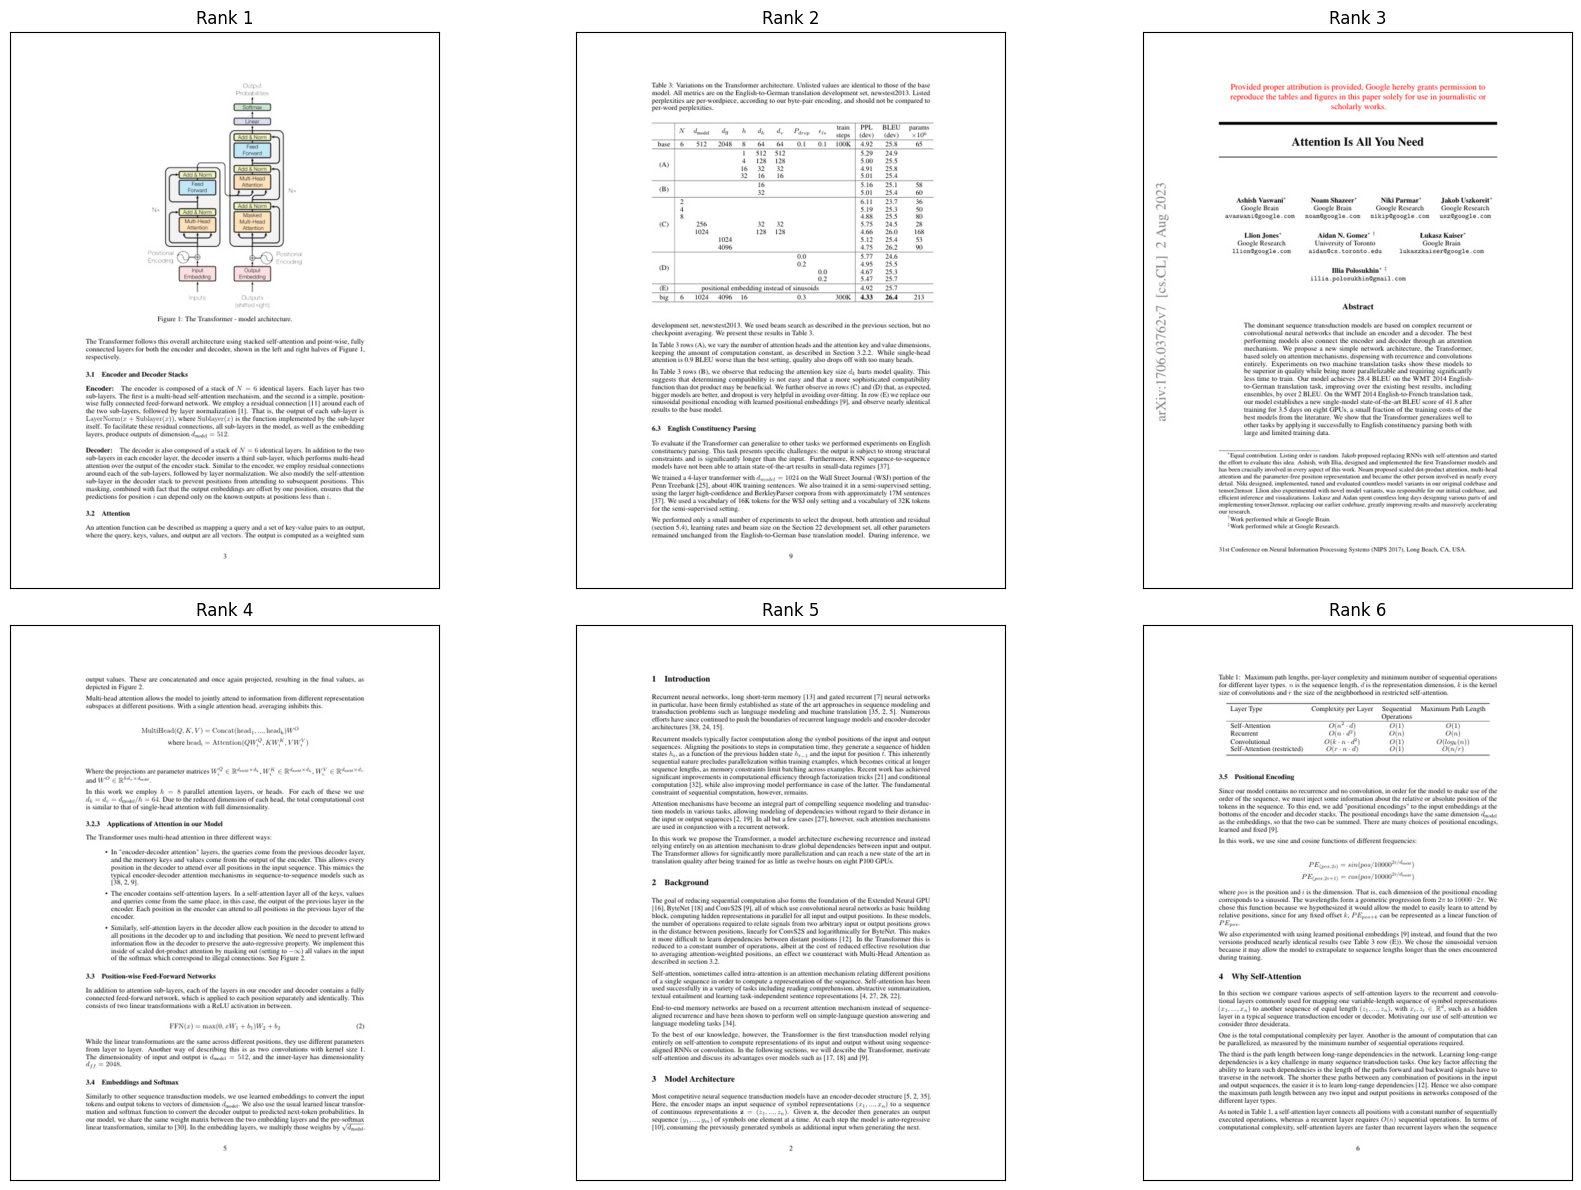

In [13]:
import matplotlib.pyplot as plt

def display_images_in_grid(image_ids, images):
    # Number of images
    num_images = len(image_ids)
    
    # Define the number of columns for the grid
    cols = 3
    # Calculate the number of rows needed
    rows = (num_images + cols - 1) // cols
    
    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Loop through the images and their corresponding axes
    for ax, image_id in zip(axes, image_ids):
        # Resize the image
        shrink_factor = (images[image_id].size[0] / 1024)
        resized_image = images[image_id].resize((int(images[image_id].size[0] / shrink_factor), 
                                                 int(images[image_id].size[1] / shrink_factor)))
        
        # Display the image in the respective subplot
        ax.imshow(resized_image)
        # Set the title for each subplot
        rank = image_ids.index(image_id) + 1
        ax.set_title(f'Rank {rank}')
        # Hide grid lines
        ax.grid(False)
        # Hide axes ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide unused axes if any
    for ax in axes[len(image_ids):]:
        ax.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

display_images_in_grid(context_ids, images)

## Interpretability

In [14]:
# Closest top K tokens 
context_ids

[2, 8, 0, 4, 1, 5]

In [15]:
# All image embeddings 
len(images_embeddings), images_embeddings

(15,
 [tensor([[-0.0216, -0.0486, -0.0449,  ...,  0.0452, -0.0249,  0.1338],
          [-0.1387, -0.0520,  0.1895,  ...,  0.0240,  0.0276, -0.0693],
          [-0.2129, -0.0039,  0.1816,  ...,  0.0466,  0.0452, -0.0325],
          ...,
          [-0.0398,  0.0618,  0.1484,  ..., -0.0562,  0.0859, -0.0742],
          [-0.0270, -0.0029,  0.1455,  ...,  0.0297,  0.0315, -0.1118],
          [-0.0830,  0.0625,  0.0576,  ...,  0.1147, -0.0461, -0.0835]],
         dtype=torch.bfloat16),
  tensor([[-2.1606e-02, -4.8584e-02, -4.4922e-02,  ...,  4.5166e-02,
           -2.4902e-02,  1.3379e-01],
          [-1.3867e-01, -5.2002e-02,  1.8945e-01,  ...,  2.4048e-02,
            2.7588e-02, -6.9336e-02],
          [-2.1289e-01, -3.9368e-03,  1.8164e-01,  ...,  4.6631e-02,
            4.5166e-02, -3.2471e-02],
          ...,
          [ 1.6117e-04,  9.3750e-02,  1.4355e-01,  ...,  9.1553e-04,
            3.7231e-03, -3.8818e-02],
          [-2.2827e-02,  1.5869e-02,  9.6191e-02,  ...,  4.6387e-02,
   

In [16]:
# All images in PIL - JpegImageFile format 
len(images), images

(15,
 [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=

In [17]:
from colpali_engine.interpretability import get_similarity_maps_from_embeddings
from colpali_engine.interpretability import plot_all_similarity_maps
from colpali_engine.interpretability import plot_similarity_map

In [18]:
def visualize_similarity_map(idx, image, query, images_embeddings, model, processor):

    # Get the device 
    device = model.device
    
    # Prreprocess inputs
    batch_images = processor.process_images([image]).to(device)
    batch_queries = processor.process_queries([query]).to(device)
    
    # Forward passes
    with torch.no_grad():
        image_embeddings = model.forward(**batch_images)
        query_embeddings = model.forward(**batch_queries)
    
    
    # Get the number of image patches
    n_patches = processor.get_n_patches(image_size=image.size, 
                                        patch_size=model.patch_size,
                                        spatial_merge_size=model.spatial_merge_size)
    
    
    
    
    # Get the tensor mask to filter out the embeddings that are not related to the image
    image_mask = processor.get_image_mask(batch_images)
    
    # Generate the similarity maps
    batched_similarity_maps = get_similarity_maps_from_embeddings(
                                                                    image_embeddings=image_embeddings,
                                                                    query_embeddings=query_embeddings,
                                                                    n_patches=n_patches,
                                                                    image_mask=image_mask,
                                                                )
    
    # Get the similarity map for our (only) input image
    similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)
    
    # Tokenize the query
    query_tokens = processor.tokenizer.tokenize(query)
    query_tokens = [item.replace('Ġ', '') for item in query_tokens]
    
    # Picking a random token 
    token_idx = np.random.choice(len(query_tokens))
    
    # Get the similarity map for our (only) input image
    fig, ax = plot_similarity_map(image, 
                                  similarity_maps[token_idx],
                                  figsize=(8, 8),
                                  show_colorbar=False)
    
    max_sim_score = similarity_maps[token_idx, :, :].max().item()
    ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

    return fig

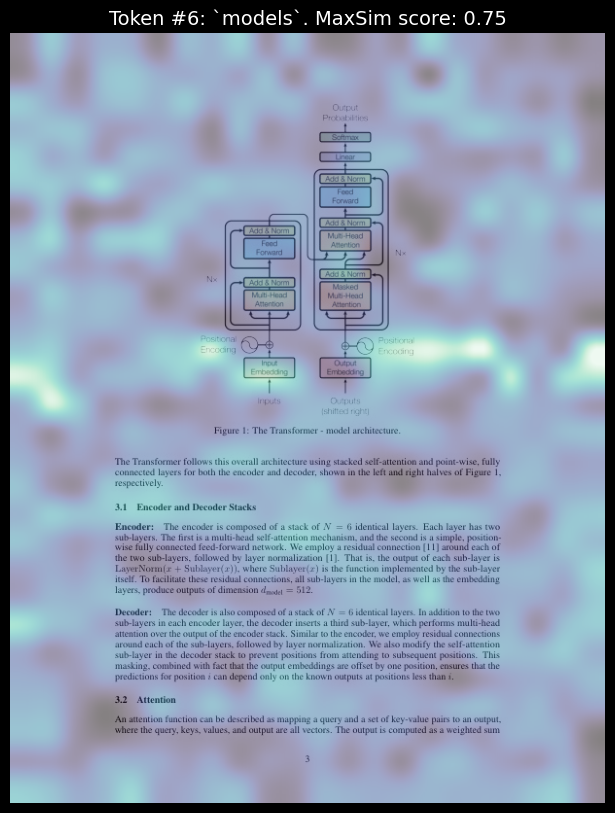

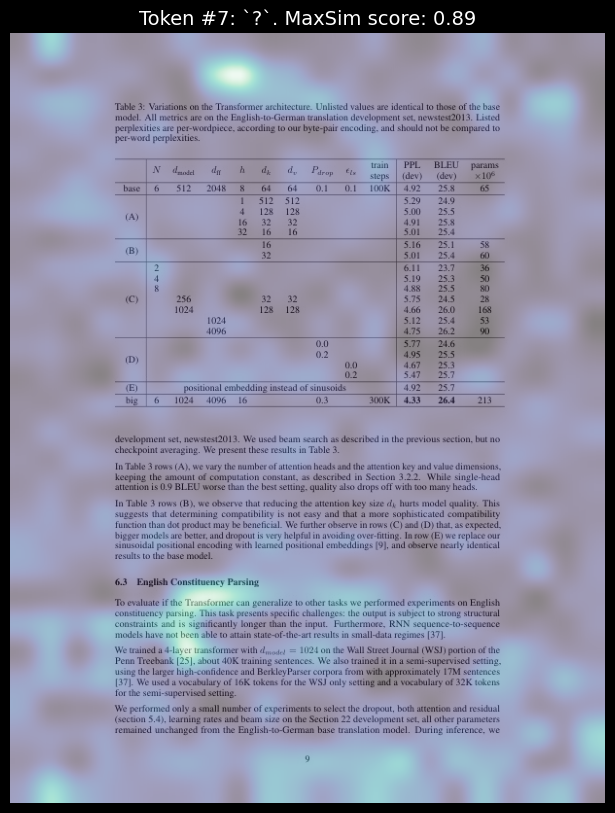

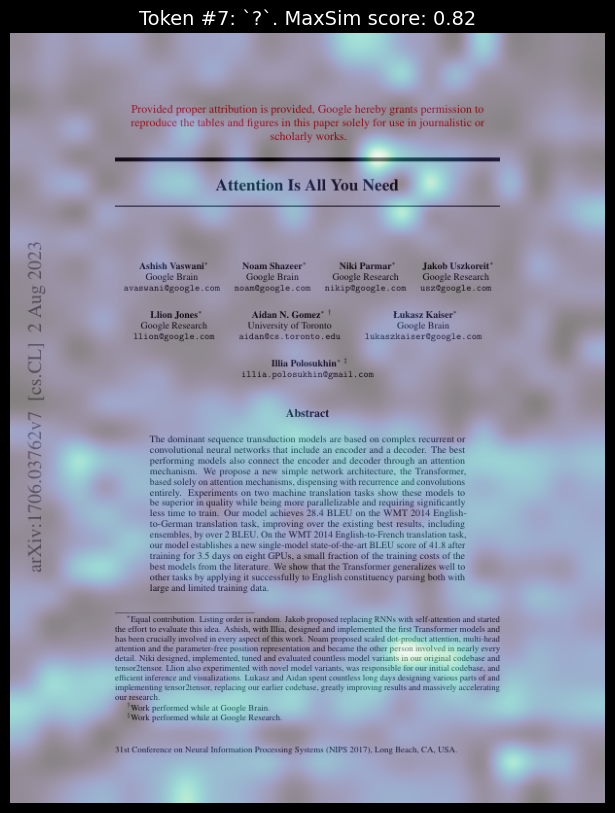

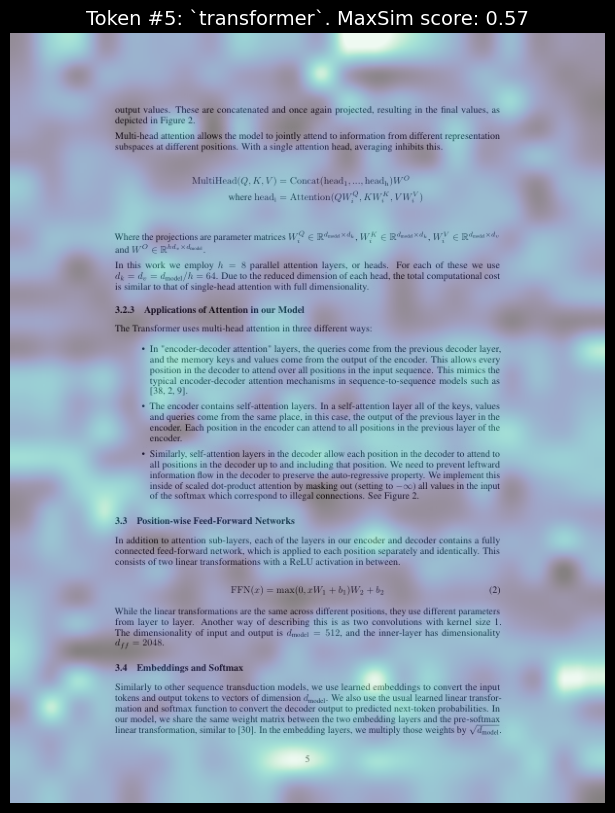

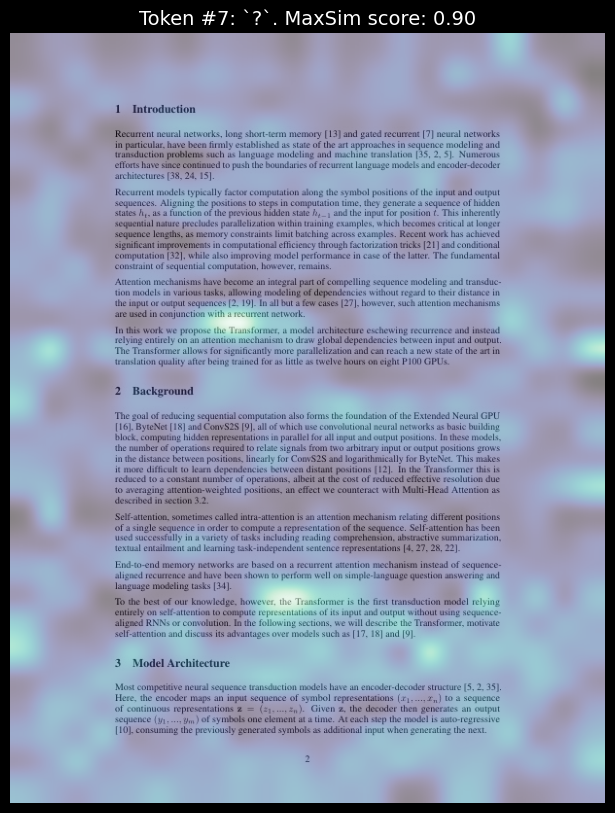

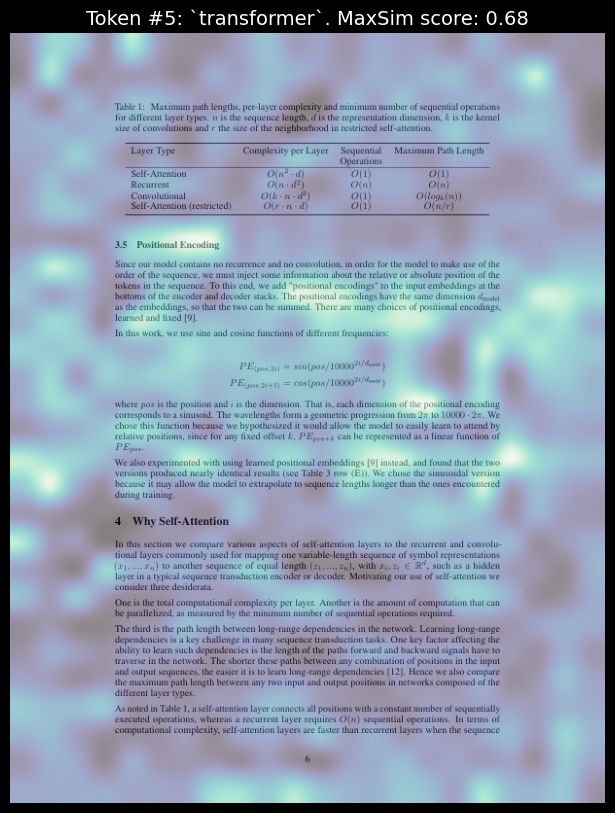

In [19]:
figs = []
for idx in context_ids:
    image = images[idx]
    fig = visualize_similarity_map(idx, image, query, images_embeddings, model, processor)
    figs.append(fig)


## Cleanup memory

In [20]:
import shutil

def cleanup_memory(device = device):
    """Clean up memory by deleting variables and running garbage collection for CPU, CUDA, or MPS"""
    import gc
    
    variables_to_clean = [
        'query_content',
        'query_tokens',
        'batch_queries',
        'batched_similarity_maps',
        'similarity_maps',
        'image_mask',
        'n_patches',
        'im'
    ]
    
    # Delete variables if they exist in global scope
    for var in variables_to_clean:
        if var in globals():
            del globals()[var]
    
    # Force garbage collection
    gc.collect()
    
    # Clear CUDA cache if using CUDA
    if device == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    else:
        torch.mps.empty_cache()

    # Delete the processed folder
    if os.path.exists("data/processed_page_images"):
        shutil.rmtree("data/processed_page_images")

    # Delete the model cache
    if os.path.exists("model_cache"):
        shutil.rmtree("model_cache")



In [21]:
# # Run cleanup
# cleanup_memory()